In [1]:
from keras.layers import Input, Dense, Embedding, Convolution1D, MaxPooling1D, MaxPooling2D, Convolution2D, LSTM
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.layers import Lambda, GlobalAveragePooling1D, Dense, Embedding
from keras.regularizers import l2, l1
from keras import regularizers
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.text import one_hot as oneHOT
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [0]:
import pandas as pd
import numpy as np
df_tweet = pd.read_csv("data/processed_tweet2.csv")
import ast
df_tweet['tweet_pr_st1'] = df_tweet.apply(lambda x: ast.literal_eval(x.tweet_pr_st1),axis =1)
df_tweet['tweet_pr_st2'] = df_tweet.apply(lambda x: ast.literal_eval(x.tweet_pr_st2),axis =1)

# df_tweet['subtask_a'] = df_tweet.apply(lambda x: 0 if x.subtask_a=='NOT' else 1,axis = 1)
# df_tweet['subtask_b'] = df_tweet.apply(lambda x: 1 if x.subtask_b=='UNT' else 2 if x.subtask_b=='TIN' else 0,axis = 1)
# df_tweet['subtask_c'] = df_tweet.apply(lambda x: 2 if (x.subtask_b=='TIN' and x.subtask_a=='OFF' and x.subtask_c=='IND') else 3 if (x.subtask_b=='TIN' and x.subtask_a=='OFF' and x.subtask_c=='GRP') else 4 if (x.subtask_b=='TIN' and x.subtask_a=='OFF' and x.subtask_c =='OTH') else 1 if (x.subtask_a=='OFF' and x.subtask_b=='UNT') else 0,axis = 1)

def conditions(x):
    if (x.subtask_b=='TIN' and x.subtask_a=='OFF' and x.subtask_c=='IND'):
        return 2
    elif (x.subtask_b=='TIN' and x.subtask_a=='OFF' and x.subtask_c=='GRP'): 
        return 3
    elif (x.subtask_b=='TIN' and x.subtask_a=='OFF' and x.subtask_c =='OTH'):
        return 4        
    elif (x.subtask_a=='OFF' and x.subtask_b=='UNT'):
        return 1
    else:
        return 0
    # return 2 if (x.subtask_b=='TIN' and x.subtask_a=='OFF' and x.subtask_c=='IND') else 3 if (x.subtask_b=='TIN' and x.subtask_a=='OFF' and x.subtask_c=='GRP') else 4 if (x.subtask_b=='TIN' and x.subtask_a=='OFF' and x.subtask_c =='OTH') else 1 if (x.subtask_a=='OFF' and x.subtask_b=='UNT') else 0

df_tweet['subtask_c_'] = df_tweet.apply(conditions,axis=1)

# df['subtask_c_'] = np.where(df['subtask_c']>=50, 'yes', 'no')

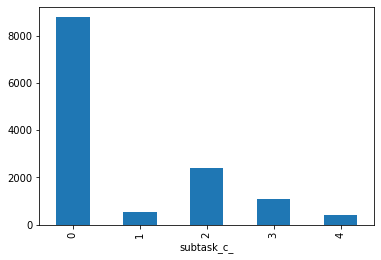

In [3]:
df_tweet.groupby(['subtask_c_']).count()['id'].plot.bar()

In [0]:
normalised_corpus = list(df_tweet['tweet_pr_st2'])
labels = list(df_tweet['subtask_c'])

In [0]:
normalised_corpus[:3]

In [0]:
import collections, itertools
word_counter = collections.Counter(list(itertools.chain.from_iterable(normalised_corpus)))

In [6]:
word_ids = list(set(list(itertools.chain.from_iterable(normalised_corpus))))
len(word_ids)

13910

In [0]:
word2idx = {}
word2idx = {token:id+3 for id,token in enumerate(word_ids)}
word2idx['<PAD>'] = 0
word2idx['<START>'] = 1
word2idx['<UNK>'] = 2
word2idx['<UNUSED>'] = 3

# word_index = {k:(v+3) for k,v in word_index.items()}
# word_index["<PAD>"] = 0
# word_index["<START>"] = 1
# word_index["<UNK>"] = 2  
# word_index["<UNUSED>"] = 3

In [0]:
idx2word = {v: k for k,v in word2idx.items()}

In [0]:
sents_as_ids = []
for i in range(len(normalised_corpus)):
    sents_as_ids.append([word2idx[j] for j in normalised_corpus[i]])

In [0]:
normalised_corpus[0:3]

In [0]:
sents_as_ids[0:3]

In [0]:
vocab_size = len(word_ids) + 3
maxlen=50

In [0]:
def one_hot(labels):
    from sklearn.preprocessing import OneHotEncoder
    encoder = OneHotEncoder()
    return encoder.fit_transform(np.array(labels).reshape(-1,1)).toarray()

labels = one_hot(labels)

In [0]:
def readGloveFile(gloveFile):
    with open(gloveFile, 'r') as f:
        wordToGlove = {}  
        wordToIndex = {}  
        indexToWord = {}  

        for line in f:
            record = line.strip().split()
            token = record[0] 
            wordToGlove[token] = np.array(record[1:], dtype=np.float64) 
            
        tokens = sorted(wordToGlove.keys())
        for idx, tok in enumerate(tokens):
            kerasIdx = idx + 1  
            wordToIndex[tok] = kerasIdx 
            indexToWord[kerasIdx] = tok 

    return wordToIndex, indexToWord, wordToGlove

In [0]:
def createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, isTrainable):
    vocabLen = len(wordToIndex) + 1  
    embDim = next(iter(wordToGlove.values())).shape[0]  
   
    embeddingMatrix = np.zeros((vocabLen, embDim))  
    for word, index in wordToIndex.items():
        embeddingMatrix[index, :] = wordToGlove[word] 

    embeddingLayer = Embedding(vocabLen, embDim, embeddings_initializer=Constant(embeddingMatrix), trainable=isTrainable)
    return embeddingLayer

In [0]:
from sklearn.model_selection import train_test_split
train_data,test_data,train_labels,test_labels = train_test_split(sents_as_ids,labels,test_size=0.2,stratify=labels)

X_train_enc = pad_sequences(train_data,
                            value=word2idx["<PAD>"],
                            padding='post',
                            maxlen=50)
X_test_enc = pad_sequences(test_data,
                            value=word2idx["<PAD>"],
                            padding='post',
                            maxlen=50)


In [16]:
# put the code here
!pip install chakin
import chakin
chakin.download(number=12, save_dir='./')

import os
os.system("unzip './glove.6B.zip' ")
from tensorflow.contrib.keras.api.keras.initializers import Constant
wordToIndex, indexToWord, wordToGlove = readGloveFile('glove.6B.300d.txt')
embeddingLayer = createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, isTrainable=True)
# os.system("rm 'embeddings/glove.6B.zip'")

Test: 100% ||                                      | Time:  0:06:29   2.1 MiB/s


In [0]:
# from keras.preprocessing.sequence import pad_sequences
# from sklearn.model_selection import train_test_split
# MAXIMUM_LENGTH = 500
# train_data,test_data,train_labels,test_labels = train_test_split(sents_as_ids,labels,test_size=0.2,stratify=labels)

# preprocessed_train_data = pad_sequences(train_data,maxlen=MAXIMUM_LENGTH)
# processed_test_data = pad_sequences(test_data,maxlen=MAXIMUM_LENGTH)

In [0]:
# print('Length of sample train_data before preprocessing:', len(train_data[1]), type(train_data[1]))

In [0]:
# print('Length of sample train_data after preprocessing:', len(preprocessed_train_data[1]), type(train_data[1]))

In [17]:
model = Sequential()
EMBED_SIZE = 100
model.add(embeddingLayer)
# model.add(Embedding(vocab_size,EMBED_SIZE,input_length=MAXIMUM_LENGTH))
# model.add(Dropout(0.08))
model.add(LSTM(100, activation='tanh'))
# model.add(Dropout(0.08))
model.add(Dense(train_labels.shape[1],activation='softmax'))
# put the code here
# model = Sequential()
# model.add(Embedding(vocab_size, 30, input_length=MAXIMUM_LENGTH))
# model.add(Convolution1D(64,5,activation="relu"))
# model.add(Dropout(0.5))
# model.add(Convolution1D(32,3,activation="relu"))
# model.add(Dropout(0.5))
# model.add(Convolution1D(16,3,activation="sigmoid"))
# model.add(MaxPooling1D(5))
# model.add(Flatten())
# model.add(Dense(train_labels.shape[1],activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         120000300 
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 404       
Total params: 120,161,104
Trainable params: 120,161,104
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# X_val = np.array(X_train_enc[:10000])
# partial_X_train = np.array(X_train_enc[10000:])

history = model.fit(X_train_enc,
                    train_labels,
                    epochs=5,
                    batch_size=64,
                    validation_split=0.2,
                    verbose=1)




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 8440 samples, validate on 2110 samples
Epoch 1/7




/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:421: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 120000300 elements. This may consume a large amount of memory.
  num_elements)





8440/8440 [==============================] - 36s 4ms/step - loss: 0.3882 - acc: 0.8457 - val_loss: 0.3812 - val_acc: 0.8504
Epoch 2/7
8440/8440 [==============================] - 20s 2ms/step - loss: 0.3718 - acc: 0.8531 - val_loss: 0.3680 - val_acc: 0.8509
Epoch 3/7
8440/8440 [==============================] - 20s 2ms/step - loss: 0.3400 - acc: 0.8635 - val_loss: 0.3620 - val_acc: 0.8537
Epoch 4/7
8440/8440 [==============================] - 20s 2ms/step - loss: 0.2889 - acc: 0.8828 - val_loss: 0.3544 - val_acc: 0.8601
Epoch 5/7
8440/8440 [==============================] - 20s 2ms/step - loss: 0.2530 - acc: 0.8966 - val_loss: 0.3848 - val_acc: 0.8415
Epoch 6/7
8440/8440 [==============================] - 20s 2ms/step - loss: 0.2263 - acc: 0.9083 - val_loss: 0.4109 - val_acc: 0.8331
Epoch 7/7
8440/8440 [==============================] - 20s 2ms/step - loss: 0.2026 - acc: 0.9204 - val_loss: 0.4165 - val_acc: 0.8275


In [19]:
results = model.evaluate(X_test_enc, test_labels)
print(results)

2638/2638 [==============================] - 1s 468us/step
[0.42076714862197345, 0.8285633055344959]


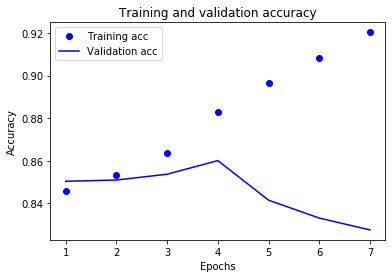

In [20]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [21]:
# put the code here
model2 = Sequential()
model2.add(embeddingLayer)
# model2.add(Convolution1D(64,5,activation="relu"))
# model2.add(Dropout(0.5))
# model2.add(Convolution1D(32,3,activation="relu"))
# model2.add(Dropout(0.5))
# model2.add(Convolution1D(16,3,activation="sigmoid"))
# model2.add(MaxPooling1D(5))
# model2.add(Flatten())
# model2.add(Dense(train_labels.shape[1],activation='softmax'))
# model2.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model2.add(Dropout(0.2))
model2.add(Convolution1D(64, 5, activation='relu'))
model2.add(MaxPooling1D(pool_size=4))
model2.add(LSTM(100))
model2.add(Dense(train_labels.shape[1],activation='softmax'))
model2.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         120000300 
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 300)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          96064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 404       
Tot

In [23]:
model2.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

# X_val = np.array(X_train_enc[:10000])
# partial_X_train = np.array(X_train_enc[10000:])

history = model2.fit(X_train_enc,
                    train_labels,
                    epochs=5,
                    batch_size=256,
                    validation_split=0.2,
                    verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:421: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 120000300 elements. This may consume a large amount of memory.
  num_elements)


Train on 8440 samples, validate on 2110 samples
Epoch 1/5
8440/8440 [==============================] - 12s 1ms/step - loss: 0.9485 - acc: 0.7013 - val_loss: 0.8645 - val_acc: 0.7009
Epoch 2/5
8440/8440 [==============================] - 3s 412us/step - loss: 0.7046 - acc: 0.7392 - val_loss: 0.9738 - val_acc: 0.7052
Epoch 3/5
8440/8440 [==============================] - 3s 410us/step - loss: 0.4851 - acc: 0.8212 - val_loss: 1.0057 - val_acc: 0.6844
Epoch 4/5
8440/8440 [==============================] - 3s 410us/step - loss: 0.4372 - acc: 0.8505 - val_loss: 1.0501 - val_acc: 0.6512
Epoch 5/5
8440/8440 [==============================] - 3s 406us/step - loss: 0.3906 - acc: 0.8678 - val_loss: 1.1486 - val_acc: 0.6242


In [24]:
results = model2.evaluate(X_test_enc, test_labels)
print(results)

2638/2638 [==============================] - 0s 168us/step
[1.2025372794941576, 0.6152388174213904]


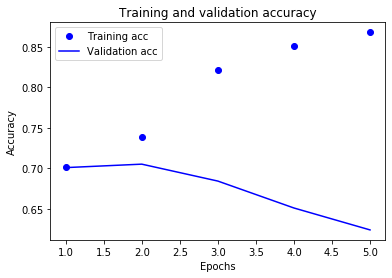

In [25]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()